In [60]:
import os,h5py,glob,time,shutil,random
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from imageio import imread, imsave, imwrite
from skimage.util import view_as_windows
from skimage import transform,io,color
from skimage.color import rgb2gray
from tqdm import tqdm_notebook as tqdm
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model, Model
import subprocess
from skimage.filters import threshold_otsu,threshold_local
from skimage.morphology import binary_closing, binary_opening, label, binary_erosion, disk




images = glob("/data/CRVI/TEST/MIRALIS/DATA/pruebatexture/*.png")
output_dir = "/data/CRVI/TEST/MIRALIS/DATA/pruebatexture/autoencoder_texture/"
#Load best model
model_name = 'autoencoder-texture'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
subprocess.call(['chmod', '-R', 'a+wrx', output_dir])
# os.makedirs(output_dir, exist_ok=True)



# model_name = 'autoencoder-texture.h5'
file = h5py.File(model_name + '.h5', 'r')
print ("File Keras version: " + file.attrs.get('keras_version').decode("utf-8") )
model = load_model(model_name + '.h5')


 
print('Load model: DONE')   


File Keras version: 2.1.6-tf
Load model: DONE


In [61]:
print('Load images: START')
x_input = []
for impath in tqdm(images):
    
    im = np.asarray(imread(impath))[:,:,:3].astype('float32') / 255.
    
#     im = im - im.min(); im /= im.max()
    im = 2*(im - 0.5) 
    x_input.append(im)
    
inp = np.stack(x_input)



print('Load images: DONE')


 


Load images: START



Load images: DONE


In [70]:
print('PREDICTION: START')

print(model_name)

pred = model.predict(inp, verbose=1)

inp = ((inp*.5)+0.5)

print('Input max {} min {}'.format(np.max(inp),np.min(inp)))
print('Pred max {} min {}'.format(np.max(pred),np.min(pred)))
diff = np.abs(pred - inp)
grayscale = rgb2gray(diff)
thresh = threshold_otsu(grayscale)
binary = diff > thresh
selem = disk(3) 
erosion = binary_erosion(binary)
closed_attr = binary_closing(binary)



print('PREDICTION: DONE')


PREDICTION: START
autoencoder-texture
80/80 [==============================] - 0s 1ms/step
Input max 1.0 min 0.7941176295280457
Pred max 0.9982284903526306 min 0.48913201689720154
PREDICTION: DONE


(80, 224, 224, 3)


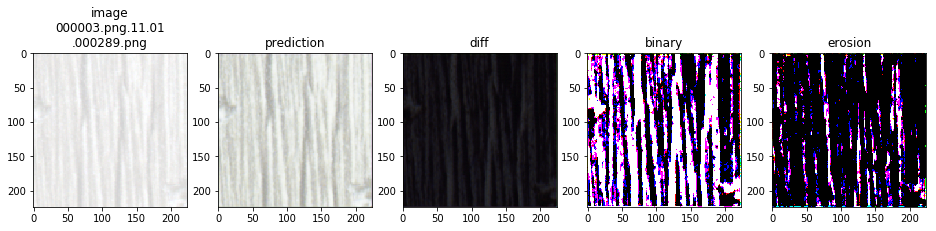

In [71]:
im1 = (inp * 255).astype(np.uint8)
im2 = (pred * 255).astype(np.uint8)
im3 = (diff * 255).astype(np.uint8)
img = (grayscale * 255).astype(np.uint8)
im4 = (binary * 255).astype(np.uint8)
im5 = (erosion * 255).astype(np.uint8)

print(im4.shape)
f = 8

plt.figure(figsize=(16,4))
name = str(os.path.basename(images[f]))
plt.subplot(151); plt.imshow(im1[f]); plt.title('image'+ '\n' + name[:16] + '\n' + name[16:] )
plt.subplot(152); plt.imshow(im2[f]); plt.title("prediction")
plt.subplot(153); plt.imshow(im3[f]); plt.title("diff")
plt.subplot(154); plt.imshow(im4[f]); plt.title("binary")
plt.subplot(155); plt.imshow(im5[f]); plt.title("erosion")
plt.show()

START
Output directory figures /data/CRVI/TEST/MIRALIS/DATA/pruebatexture/autoencoder_texture/


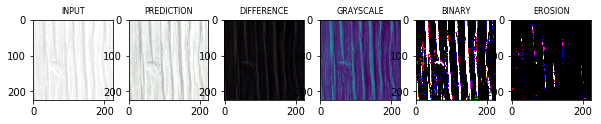

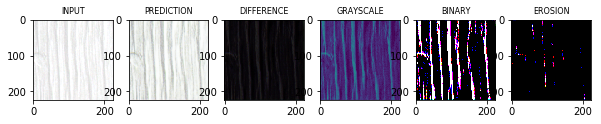

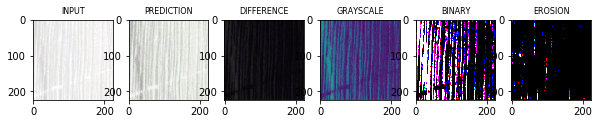

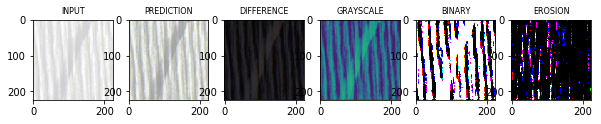

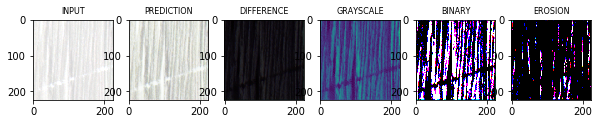

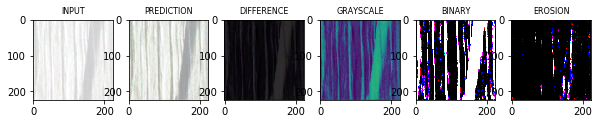

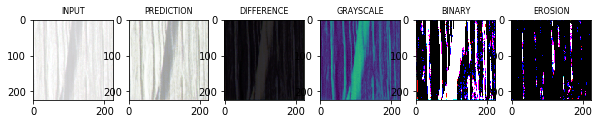

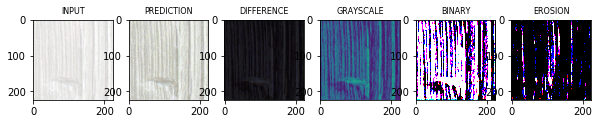

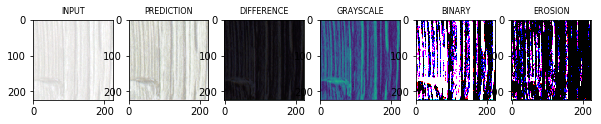

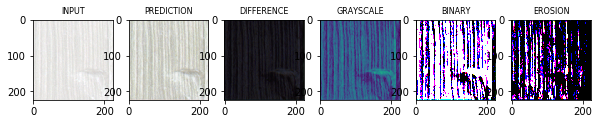

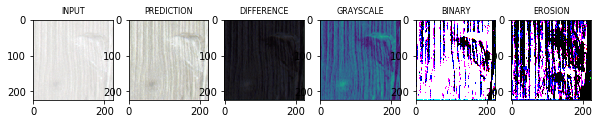

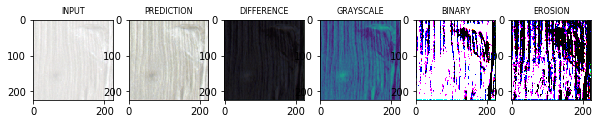

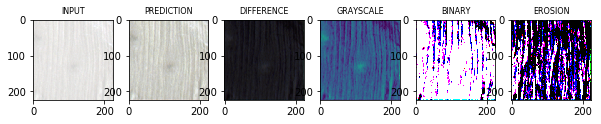

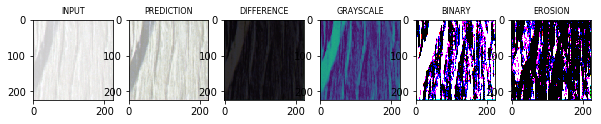

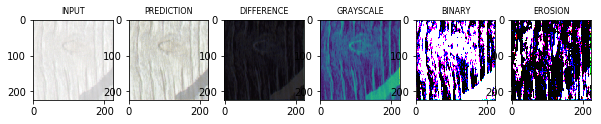

DONE


In [74]:
print ("START")

print('Output directory figures',output_dir)

def do_plot(ax, Z, TI, cmap=None, colors=None):  
    
   
    im = ax.imshow(Z,cmap=cmap)
    ax.set_title(TI,fontsize=8)
    

nimages = 10;

for i in range(65,80):
   
    fig, (ax1, ax2, ax3, ax4, ax5,ax6) = plt.subplots(1, 6,figsize=(10, 10))
#     name = str(os.path.basename(images[i]))
#     ax3.set_xlabel(name[:16] + '\n' + name[16:])
    do_plot(ax1,im1[i],'INPUT')
    do_plot(ax2,im2[i],'PREDICTION')
    do_plot(ax3,im3[i],'DIFFERENCE')    
    do_plot(ax4,img[i],'GRAYSCALE')
    do_plot(ax5,im4[i],'BINARY')
    do_plot(ax6,im5[i],'EROSION')
    #     binary_1 = image[i] > threshold_local(image[i], 15, 'mean')
#     do_plot(ax6,binary_1,'BINARY')

    plt.savefig(os.path.join(output_dir, model_name +'comparison.png'))
    plt.show()

print ("DONE")

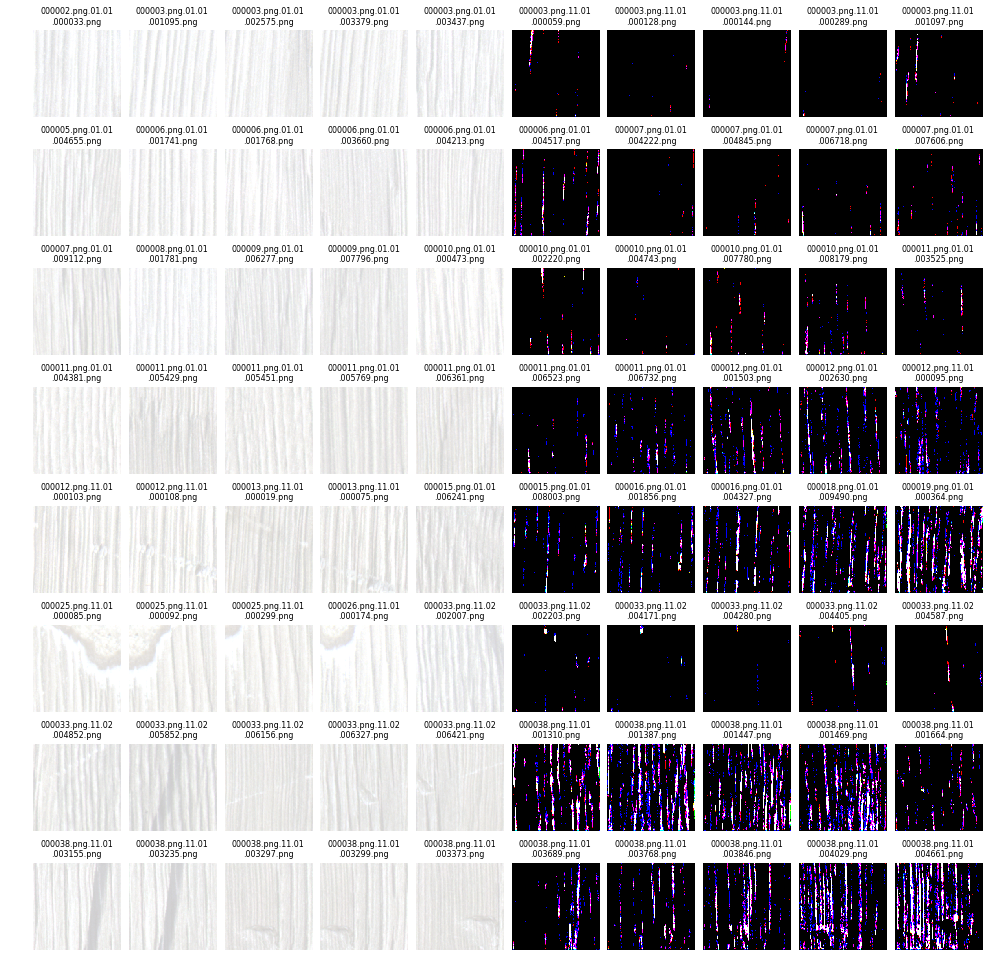

In [76]:
   
fig = plt.figure(figsize=(17, 17))
fig.subplots_adjust(hspace=0.3, wspace=0.1)



for i in range(0,80):
    ix = np.fix(i/5) % 2
    name = str(os.path.basename(images[i]))      
    imsave(os.path.join(output_dir, name), im5[i])
    
    ax = fig.add_subplot(8, 10, i+1)  
    plt.axis('off')
    
    
    
    if ix==0:
        do_plot(ax,im1[i],name[:16] + '\n' + name[16:])
#         ax.imshow((inp[i]*255).astype(np.uint8))
    else:
        do_plot(ax,im5[i-5],name[:16] + '\n' + name[16:])
#         ax.imshow((binary[i-5]*255).astype(np.uint8))
        
#     ax.set_xlabel(name[:16] + '\n' + name[16:],fontsize=8)    
plt.savefig(os.path.join(output_dir, model_name + 'erosion.png'))